## Convolutional Neural Net
- CFRA dataset
    - 10 class of objects
    
- convolution
    - convolutional filter
    - pooling
        - max
        - average: reduce the size of the image

In [81]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


# device configruation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
EPOCHS = 4
batch_size = 8
learning_rate = 0.0001

# dataset has PILImge Images of range [0, 1]
# we trasnform them to tensor of range [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # how does this works?
])

train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, transform=transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

classes = [
    'plane', 'car', 'bird', 'cat', 'deer',
    'dog', 'frog', 'hourse', 'ship', 'truck'
]

# implement conv net
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5) # not specifing the image size
        # only the channel (input channel, output channel, filter size)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(16*5*5, 128) # why 5*5 ?       
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.reshape(batch_size, -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    
# model
model = ConvNet().to(device)

# loss and optimizer
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# trianing loop
n_total_steps = len(train_loader)
for epoch in range(EPOCHS):
    for i, (images, labels) in enumerate(train_loader):
        # original shape: [4, 3, 32, 32]
        # input_layer: 3 input channels, 6 output channels, 5 kernal size
        images = images.to(device)
        labels = labels.to(device)

        # forward path
        output = model(image)
        l = loss(output, labels)
        
        # zero gradients
        optimizer.zero_grad()
        
        # backward path
        l.backward()
        
        # update weights
        optimizer.step()
        
        # print the training infromation
        if (i+1) % 1000 == 0:
            print(f'epoch: {epoch+1}/{EPOCHS} batch {i+1}/{n_total_steps} loss={l}')
            
            
# evaluate the accuracy on testing data
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        output = model(image)
        
        _, prediction = torch.max(output, 1)
        n_samples += images.shape[0]
        n_correct = (labels == prediction).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = prediction[i]
            if label == pred:
                n_class_correct[label] += 1
            n_class_samples[label] += 1
                
        
    acc = n_correct/n_samples * 100
    print(f'accuracy = {acc}')
    
    for i in range(10):
        acc = 100 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc}%')    


Files already downloaded and verified
epoch: 1/4 batch 1000/6250 loss=2.289154291152954
epoch: 1/4 batch 2000/6250 loss=2.2451188564300537
epoch: 1/4 batch 3000/6250 loss=2.2808167934417725
epoch: 1/4 batch 4000/6250 loss=2.307161331176758
epoch: 1/4 batch 5000/6250 loss=2.288994312286377
epoch: 1/4 batch 6000/6250 loss=2.294752597808838
epoch: 2/4 batch 1000/6250 loss=2.3351097106933594
epoch: 2/4 batch 2000/6250 loss=2.3103585243225098
epoch: 2/4 batch 3000/6250 loss=2.3388471603393555
epoch: 2/4 batch 4000/6250 loss=2.3141510486602783
epoch: 2/4 batch 5000/6250 loss=2.257997989654541
epoch: 2/4 batch 6000/6250 loss=2.332366466522217
epoch: 3/4 batch 1000/6250 loss=2.306548595428467
epoch: 3/4 batch 2000/6250 loss=2.290867805480957
epoch: 3/4 batch 3000/6250 loss=2.302588701248169
epoch: 3/4 batch 4000/6250 loss=2.2870681285858154
epoch: 3/4 batch 5000/6250 loss=2.321716785430908
epoch: 3/4 batch 6000/6250 loss=2.2967896461486816
epoch: 4/4 batch 1000/6250 loss=2.3404464721679688
epo

## Convolution size calculation
- size of the image after convolution
- [(W-K+2P)/S]+1
    - W: input image width
    - K: kernel size
    - P: padding
    - S: stride
  
- example
- input image of size 32x32
- kernel size = 5
- stride = 1
- padding = 0

- output image size = (32-5) + 1 = 28

## problems
- test_loader.next(): is not working
- next() available with an iter

## Solution
- need to convert the test_loader to a iterator
    - iter(test_loader)
- then we can use the next() attrib

In [53]:
# get a sample from the train data
example = iter(train_loader)
image, label = example.next()
img = image[0]

In [54]:
print(f'image shape before convolution: {img.shape}')
out = nn.Conv2d(3, 16, 5)(torch.unsqueeze(img, 0))
print(f'image shape after convolution: {out.shape}')

image shape before convolution: torch.Size([3, 32, 32])
image shape after convolution: torch.Size([1, 16, 28, 28])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([8, 3, 32, 32]) torch.Size([8])


IndexError: index 4 is out of bounds for axis 0 with size 4

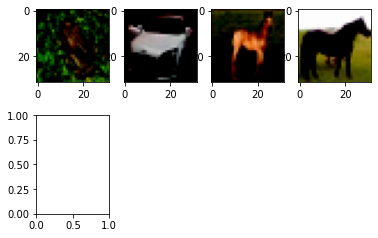

In [64]:
# check all are working good
example = iter(train_loader)
samples, labels = example.next()
print(samples.shape, labels.shape)

for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(np.moveaxis(image.numpy()[i], 0, 2))
plt.show()

In [79]:
with torch.no_grad():
    _, out = torch.max(model(samples), 1)
    print(out)
    print(labels)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([3, 5, 3, 8, 3, 5, 1, 7])
